# Proyecto Statistical Learning I
##### Autor: Lilian Rebeca Carrera Lemus

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 30 de mayo. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

### Parte 2 - Modelo polinomial de calidad de vinos

In [1]:
pip install tensorboard_logger

In [2]:
#Importar librerías a utilizar
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from tensorboard_logger import tensorboard_logger, log_value
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import datetime
from scipy import stats
%load_ext tensorboard

In [3]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


## 1.  Entrenamiento, Selección y Validación

In [4]:
df_data = pd.read_csv('data_titanic_proyecto.csv')
df_data.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


**Descripción de variables:**  
* ***PassengerId:*** identificador único del pasajero
* ***Name:*** nombre del pasajero
* ***Age:*** edad del pasajero
* ***SibSp:*** número de hermanos(as) y hermanastros(as) en el barco
* ***Parch:*** número de padres e hijos en el barco.
* ***Ticket:*** identificador del boleto
* ***Fare:*** precio pagado por el boleto
* ***Cabin:*** identificador del camarote asignado al pasajero
* ***Embarked:*** puerto en el que embarcó el pasajero (C= Cherbourg, Q= Queenstown, S= Southampton)
* ***passenger_class:*** clase a la que pertenecía el pasajero
* ***passenger_sex:*** sexo del pasajero, masculino(M) y femenino(F)
* ***passenger_survived:*** indica si el pasajero sobrevivió al naufragio. Si (Y) o no sobrevivió (N)

In [5]:
#Debido a que los nombres de las variables son muy grandes, cambiaremos algunas con nombres más cortos para que sea más fácil su mnipulación
df_data = df_data.rename(columns={'passenger_class':'Pclass', 'passenger_sex':'Sex', 'passenger_survived':'Survived'})

df_data.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass,Sex,Survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


**Tipos de Características**
* Características numéricas: 
    * Age (continua)
    * Fare (continua)
    * SibSp (discreta) 
    * Parch (discreta)
* Características categóricas: 
    * Survived
    * Sex 
    * Embarked
    * Pclass
* Características alfanuméricas: 
    * Ticket 
    * Cabin
* Identificadores y nombres:
    * PassengerId
    * Name

In [6]:
#contamos con 891 observaciones y 12 variables, 11 variables independientes y nuestra variable dependiente
np.shape(df_data)

(891, 12)

In [7]:
#Información importante del dataset 
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Name         891 non-null    object 
 2   Age          714 non-null    float64
 3   SibSp        891 non-null    int64  
 4   Parch        891 non-null    int64  
 5   Ticket       891 non-null    object 
 6   Fare         891 non-null    float64
 7   Cabin        204 non-null    object 
 8   Embarked     889 non-null    object 
 9   Pclass       891 non-null    object 
 10  Sex          891 non-null    object 
 11  Survived     891 non-null    object 
dtypes: float64(2), int64(3), object(7)
memory usage: 83.7+ KB


In [8]:
#Verificamos los valores faltantes y nulos en los datos
#Las variables de edad y número de cabina cuentan con valores nulos
df_data.isnull().sum()

PassengerId      0
Name             0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Pclass           0
Sex              0
Survived         0
dtype: int64

In [9]:
#Estadísticos importantes sobre las variables númericas
df_data.describe()

,PassengerId,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,29.699118,0.523008,0.381594,32.204208
std,257.353842,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,38.000000,1.000000,0.000000,31.000000
max,891.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
#Verificamos también alguna información disponible de las variables categoricas
df_data.describe(include = "all")

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass,Sex,Survived
count,891.000000,891,714.000000,891.000000,891.000000,891,891.000000,204,889,891,891,891
unique,NaN,891,NaN,NaN,NaN,681,NaN,147,3,3,2,2
top,NaN,"Elsbury, Mr. William James",NaN,NaN,NaN,347082,NaN,G6,S,Lower,M,N
freq,NaN,1,NaN,NaN,NaN,7,NaN,4,644,491,577,549
mean,446.000000,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN,NaN,NaN,NaN
std,257.353842,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,223.500000,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN,NaN,NaN,NaN
50%,446.000000,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN,NaN,NaN
75%,668.500000,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN,NaN,NaN,NaN


De acuerdo al análisis realizado hasta el momento podemos observar:  

* Hay un total de 891 pasajeros el el dataset proporcionado.
* La característica de edad tiene valores faltantes, sin embargo es una variable importante y que influye en la supervivencia de un pasajero, por lo cual tenemos que completar los campos faltantes.
* A la variable cabina le faltan mucho más de la mitad de los valores, por lo cual sería difícil completar los valores faltantes, por lo cual eliminaremos esta variable de nuestro conjunto de datos.
* A la variable de embarque le faltan solo dos valores, lo cual es muy poco y serán llenados con la clase que más se repite.
* Las característica Ticket puede eliminarse de nuestro análisis ya que contiene una alta proporción de duplicados y puede que no haya una correlación entre Ticket y la supervivencia.
* La característica PassengerId puede ser eliminada del conjunto de datos ya que no contribuye a la supervivencia.
* La característica de nombre es relativamente no estándar, puede no contribuir directamente a la supervivencia, sin embargo transformandola podríamos obtener información importante.

In [11]:
#Eliminamos las características que no son necesarias, de acuerdo al análisis previo
df_data.drop(['PassengerId'], axis=1,inplace=True )
df_data.drop(['Cabin'], axis=1,inplace=True )
df_data.drop(['Ticket'], axis=1,inplace=True )

In [12]:
#Completamos los valores faltantes en el conjunto de datos

#completamos la edad con la mediana 
df_data['Age'].fillna(df_data['Age'].median(), inplace = True)

#Completamos el embarque con la moda, ya que esta es una variable categórica 
df_data['Embarked'].fillna(df_data['Embarked'].mode()[0], inplace = True)

Para proceder con el análisis cuantitativo de datos, se procederá a convertir la variable obejtivo a valor númerico

In [13]:
df_data['Survived'].replace(to_replace=['Y','N'], value=[1,0],inplace=True)

df_data.head()

,Name,Age,SibSp,Parch,Fare,Embarked,Pclass,Sex,Survived
0,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,S,Lower,M,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,C,Upper,F,1
2,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,S,Lower,F,1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,S,Upper,F,1
4,"Allen, Mr. William Henry",35.0,0,0,8.0500,S,Lower,M,0


Verificaremos cada columna del conjunto de datos, para verficar si las que elegimos si son necesarios o no, de acuerdo a como aportan en la cantidad de personas que sobrevivieron o no.

In [14]:
print('Porcentaje de personas que Sobrevivieron al naufragio', round(df_data.Survived.sum()/df_data.Survived.count()*100, 2))
print('Porcentaje de personas que No sobrevivieron al naufragio', round([df_data["Survived"] == 0][0].sum()/df_data.Survived.count()*100, 2))

Porcentaje de personas que Sobrevivieron al naufragio 38.38
Porcentaje de personas que No sobrevivieron al naufragio 61.62


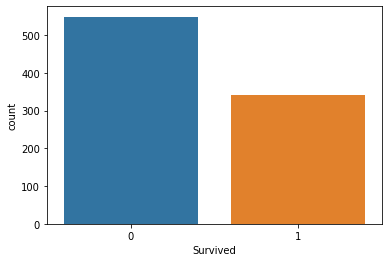

In [15]:
#Cuantas personas sobrevivieron y cuantas no
#Se puede observar que la mayoría de personas no sobrevivió al naufragio
sns.countplot(x='Survived', data=df_data);

**Variables Categóricas**

Sex
F    74.20
M    18.89
Name: Survived, dtype: float64


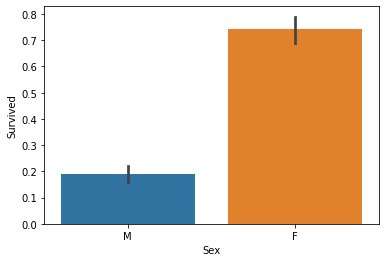

In [16]:
#Empezamos con el Sexo del pasajero
#podemos observar que de acuerdo al lema de mujeres y niños primero, efectivamente, sobrevivieron más mujeres que hombres
print(round(df_data.groupby(['Sex'])['Survived'].mean()*100,2))
sns.barplot(x="Sex", y="Survived", data=df_data)

Porcentaje sobrevivientes de la clase <pandas.core.groupby.generic.DataFrameGroupBy object at 0x000001C1577D0C08> Pclass
Lower     24.24
Middle    47.28
Upper     62.96
Name: Survived, dtype: float64


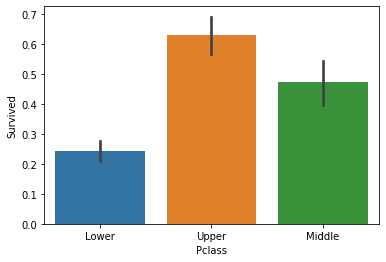

In [17]:
#para Pclass
#podemos observar que sobrevivieron más personas de la case alta y clase media
print('Porcentaje sobrevivientes de la clase', df_data.groupby(['Pclass']), round(df_data.groupby(['Pclass'])['Survived'].mean()*100,2))
sns.barplot(x="Pclass", y="Survived", data=df_data)

Embarked
C    55.36
Q    38.96
S    33.90
Name: Survived, dtype: float64


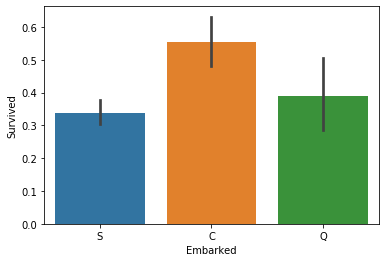

In [18]:
#Para el puerto en el que embarcó el pasajero
#Sobrebvivieron más pasajeros que embarcaron en Cherbourg
print(round(df_data.groupby(['Embarked'])['Survived'].mean()*100,2))
sns.barplot(x="Embarked", y="Survived", data=df_data)

**Variables Númericas**

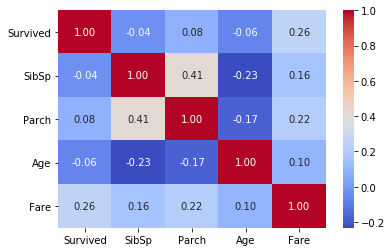

In [19]:
#Matriz de correlación entre las variables númericas (SibSp, Parch, Age, y Fare) y la variable objetivo Surivived
Mcorrelacion = sns.heatmap(df_data[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Solo la variable de Fare parece tener una correlación significativa con la probabilidad de supervivencia, sin embargo, esto no significa que las otras características no sean útiles. Las subpoblaciones en estas características se pueden correlacionar con la supervivencia. Para determinar esto, vamos a explorar más a detalle estas características

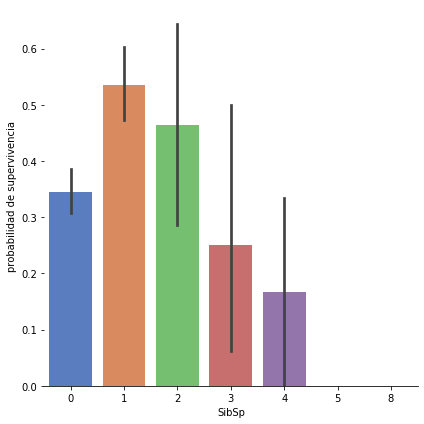

In [20]:
# Para la característica SibSp vs Survived
g = sns.catplot(x="SibSp", y="Survived", data=df_data, kind="bar", height = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("probabilidad de supervivencia")

De acuerdo con la gráfica, parece que los pasajeros que tienen varios hermanos/cónyuge tienen menos posibilidades de sobrevivir, así mismo, los pasajeros que viajaban solos (SibSP = 0) o con otras dos personas (SibSP 1 o 2) tienen más posibilidades de sobrevivir.  
Tomando en cuenta esta información podemos considerar una nueva característica que describa estas categorías

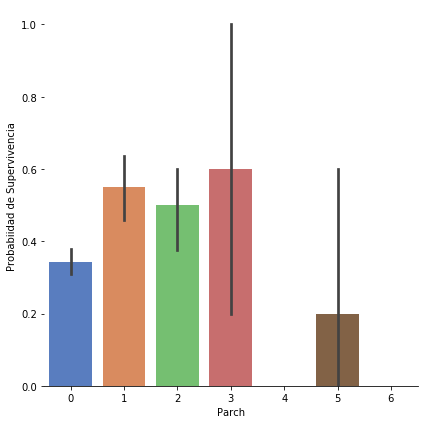

In [21]:
#Para Parch vs Survived
g  = sns.catplot(x="Parch", y="Survived", data=df_data, kind="bar", height = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Probabiidad de Supervivencia")

Las familias pequeñas tienen más posibilidades de sobrevivir, más que los que viajan sin padres e hijos (Parch=0), familias medianas (Parch 3,4) y familias grandes (Parch 5,6). También se puede observar que hay una desviación estándar importante en la supervivencia de los pasajeros con Parch=3.

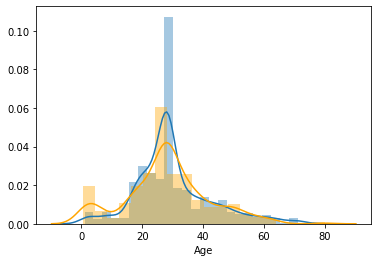

In [22]:
#Distribución para la edad
sns.distplot(df_data['Age'][df_data['Survived']==0]) 
sns.distplot(df_data['Age'][df_data['Survived']==1], color = 'orange')

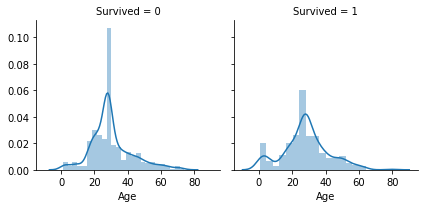

In [23]:
g = sns.FacetGrid(df_data, col='Survived')
g = g.map(sns.distplot, "Age")

La distribución por edad parece ser una distribución gaussiana.
Asi, mismo, podemos notar que las distribuciones de edad no son las mismas para survived=0(No sobrevivientes) y survived=1(Sobrevivientes). Hay un pico correspondiente a los pasajeros jóvenes que han sobrevivido. También vemos que los pasajeros entre 60 y 80 han sobrevivido menos.  
También podemos ver que hay categorías de edad de pasajeros que tienen más o menos posibilidades de sobrevivir. Pareciera que los pasajeros muy jóvenes tienen más posibilidades de sobrevivir.  

Cuando superponemos las dos densidades, vemos claramente un procentaje mayor de sobrevivencia (entre 0 y 5) para bebés y niños muy pequeños.

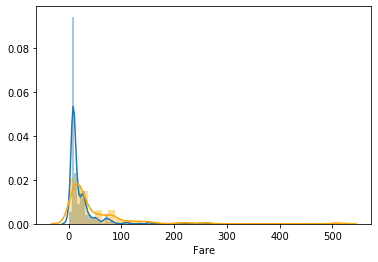

In [24]:
sns.distplot(df_data['Fare'][df_data['Survived']==0])
sns.distplot(df_data['Fare'][df_data['Survived']==1], color='Orange')

Para las características de SibSp y Parch, vamos a agregar estas dos columnas a una nueva variable llamada Family, ya que por si solas estás variables no aportan mucho a nuestro modelo.


Podemos imaginar que las familias numerosas tendrán más dificultades para evacuar, buscando a sus hermanas, hermanos, padres durante la evacuación. Entonces, se creará una variable "Fsize" (tamaño de familia) que es la suma de SibSp, Parch y 1 (incluido el pasajero)

In [25]:
df_data['Fsize']=df_data['SibSp'] + df_data['Parch'] + 1

df_data['Fsize'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: Fsize, dtype: int64

In [26]:
print(round(df_data.groupby(['Fsize'])['Survived'].mean()*100,2))

Fsize
1     30.35
2     55.28
3     57.84
4     72.41
5     20.00
6     13.64
7     33.33
8      0.00
11     0.00
Name: Survived, dtype: float64


El tamaño de la familia parece jugar un papel importante, la probabilidad de supervivencia es peor para las familias numerosas, por lo cual se crearán 4 categorías de tamaño de familia.

In [27]:
df_data['Single'] = df_data['Fsize'].map(lambda s: 1 if s == 1 else 0)
df_data['SmallF'] = df_data['Fsize'].map(lambda s: 1 if  s == 2  else 0)
df_data['MedF'] = df_data['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df_data['LargeF'] = df_data['Fsize'].map(lambda s: 1 if s >= 5 else 0)
df_data.head()

,Name,Age,SibSp,Parch,Fare,Embarked,Pclass,Sex,Survived,Fsize,Single,SmallF,MedF,LargeF
0,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,S,Lower,M,0,2,0,1,0,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,C,Upper,F,1,2,0,1,0,0
2,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,S,Lower,F,1,1,1,0,0,0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,S,Upper,F,1,2,0,1,0,0
4,"Allen, Mr. William Henry",35.0,0,0,8.0500,S,Lower,M,0,1,1,0,0,0


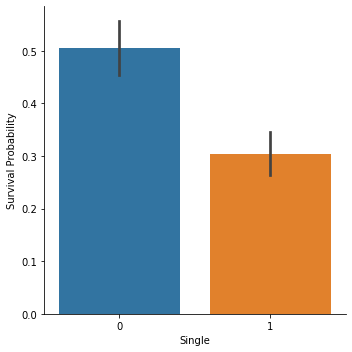

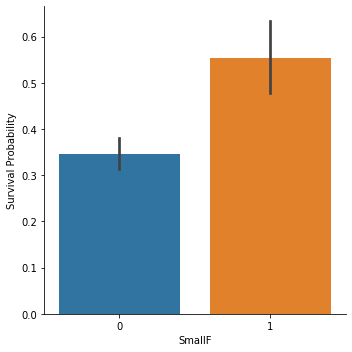

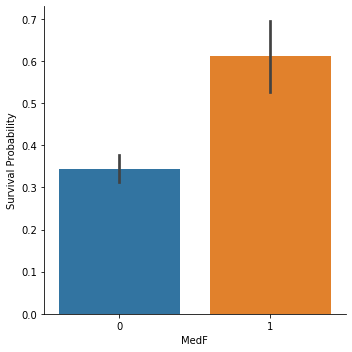

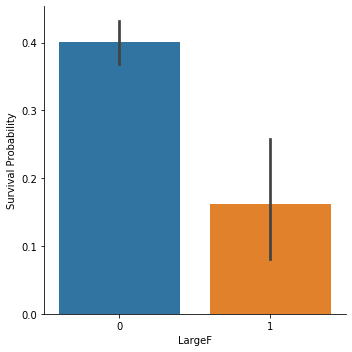

In [28]:
gFS = sns.catplot(x="Single",y="Survived",data=df_data,kind="bar")
gFS = gFS.set_ylabels("Survival Probability")
gFS = sns.catplot(x="SmallF",y="Survived",data=df_data,kind="bar")
gFS = gFS.set_ylabels("Survival Probability")
gFS = sns.catplot(x="MedF",y="Survived",data=df_data,kind="bar")
gFS = gFS.set_ylabels("Survival Probability")
gFS = sns.catplot(x="LargeF",y="Survived",data=df_data,kind="bar")
gFS = gFS.set_ylabels("Survival Probability")

Las gráficas de las categorías de tamaño de familia muestran que las familias pequeñas y medianas tienen más posibilidades de sobrevivir que los pasajeros individuales y las familias numerosas.

In [29]:
# Convertimos la variable Sex en un valor categórico 0 para masculino y 1 para femenino
df_data["Sex"] = df_data["Sex"].map({"M": 0, "F":1})

In [30]:
#Realizamos one-hot encoding a la variable categorica de Embarked
df_data = pd.get_dummies(df_data, columns = ["Embarked"], prefix="Em")

In [31]:
#Realizamos one-hot encoding a la variable categorica de Pclass
#df_data["Pclass"] = df_data["Pclass"].astype("category")
df_data = pd.get_dummies(df_data, columns = ["Pclass"],prefix="Pc")

In [32]:
df_data.head()

,Name,Age,SibSp,Parch,Fare,Sex,Survived,Fsize,Single,SmallF,MedF,LargeF,Em_C,Em_Q,Em_S,Pc_Lower,Pc_Middle,Pc_Upper
0,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,0,0,2,0,1,0,0,0,0,1,1,0,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,1,1,2,0,1,0,0,1,0,0,0,0,1
2,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,1,1,1,1,0,0,0,0,0,1,1,0,0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,1,1,2,0,1,0,0,0,0,1,0,0,1
4,"Allen, Mr. William Henry",35.0,0,0,8.0500,0,0,1,1,0,0,0,0,0,1,1,0,0


In [33]:
#Eliminamos las columnas que no son necesarias para el entrenamiento
df_data.drop(['SibSp','Parch', 'Fsize', 'Name'], axis=1,inplace=True )

In [34]:
df_data.head()

,Age,Fare,Sex,Survived,Single,SmallF,MedF,LargeF,Em_C,Em_Q,Em_S,Pc_Lower,Pc_Middle,Pc_Upper
0,22.0,7.2500,0,0,0,1,0,0,0,0,1,1,0,0
1,38.0,71.2833,1,1,0,1,0,0,1,0,0,0,0,1
2,26.0,7.9250,1,1,1,0,0,0,0,0,1,1,0,0
3,35.0,53.1000,1,1,0,1,0,0,0,0,1,0,0,1
4,35.0,8.0500,0,0,1,0,0,0,0,0,1,1,0,0


**Train, val, test Split**

In [35]:
#dividimos el data set en información de entrenamiento y pruebas primero
df_train, df_test = train_test_split(df_data, test_size=0.40, random_state=42, shuffle=True)

print('Longitud del data set completo: ',len(df_data))
print('Longitud del data set de entrenamiento: ',len(df_train))
print('Longitud del data set de pruebas: ',len(df_test))

Longitud del data set completo:  891
Longitud del data set de entrenamiento:  534
Longitud del data set de pruebas:  357


In [36]:
#Volvemos a dividir los datos para datos de pruebas y datos de validación
df_test, df_val = train_test_split(df_test, test_size=0.50, random_state=42, shuffle=True)

print('Longitud del data set de pruebas: ',len(df_test))
print('Longitud del data set de validación: ',len(df_val))

Longitud del data set de pruebas:  178
Longitud del data set de validación:  179


**Sampleo bootstrap**  
Usando muestras de tamaño 400

In [159]:
#Obtenemos un data frame para x con todas las variables independientes y una para Y con la variable a predecir
cols_x = df_train.columns.tolist()
cols_x.remove('Survived')
#Datos Entrenamiento
y_train = df_train['Survived']
x_train = pd.DataFrame(data = df_train, columns = cols_x)

#Datos Validación
y_val = df_val['Survived']
x_val = pd.DataFrame(data = df_val, columns = cols_x)

In [160]:
x_train_m1, y_train_m1 = resample(x_train, y_train, n_samples = 400)
x_train_m2, y_train_m2 = resample(x_train, y_train, n_samples = 400)
x_train_m3, y_train_m3 = resample(x_train, y_train, n_samples = 400)
x_train_m4, y_train_m4 = resample(x_train, y_train, n_samples = 400)

In [161]:
x_val_m1, y_val_m1 = resample(x_val, y_val, n_samples = 100)
x_val_m2, y_val_m2 = resample(x_val, y_val, n_samples = 100)
x_val_m3, y_val_m3 = resample(x_val, y_val, n_samples = 100)
x_val_m4, y_val_m4 = resample(x_val, y_val, n_samples = 100)

In [39]:
#Para la regresión 
x_train_m4['Bias']=1
cols = x_train_m4.columns.tolist()
cols = cols[-1:] + cols[:-1]
x_train_m4 = pd.DataFrame(data = x_train_m4, columns = cols)
x_train_m4

C:\Users\Rebeca\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Bias,Age,Fare,Sex,Single,SmallF,MedF,LargeF,Em_C,Em_Q,Em_S,Pc_Lower,Pc_Middle,Pc_Upper
202,1,34.0,6.4958,0,1,0,0,0,0,0,1,1,0,0
598,1,28.0,7.2250,0,1,0,0,0,1,0,0,1,0,0
615,1,24.0,65.0000,1,0,0,1,0,0,0,1,0,1,0
4,1,35.0,8.0500,0,1,0,0,0,0,0,1,1,0,0
496,1,54.0,78.2667,1,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,1,18.0,227.5250,1,0,1,0,0,1,0,0,0,0,1
324,1,28.0,69.5500,0,0,0,0,1,0,0,1,1,0,0
576,1,34.0,13.0000,1,1,0,0,0,0,0,1,0,1,0
579,1,32.0,7.9250,0,1,0,0,0,0,0,1,1,0,0


In [40]:
#Función para el cáclulo de las métricas de evaluación solicitadas
def metricas_evaluacion(y_real, y_pred):
    acurracy = accuracy_score(y_real, y_pred)
    error = 1 - acurracy
    precision = precision_score(y_real, y_pred)
    recall = recall_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)
    
    return (acurracy, error, precision,recall,f1)

### Modelo1: Árbol de decisión con sklearn

In [168]:
#Definición de la función para entrenar nuestro modelo
def entrenamiento_arbol(x_train, y_train, x_val, y_val,  max_depth = None, min_samples_split = 2, min_samples_leaf = 1):
    # cadena para los datos del experimento
    columnas = x_train.columns.tolist()
    string = '/experimentos/'+"arbol_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+"_maxdepth=" + str(max_depth) \
    + "_minsamplesplit=" + str(min_samples_split) + "_minsampleleaf=" + str(min_samples_leaf)
    
    dirlog = tensorboard_logger.Logger(string)
    # Desicion trees
    modelo_arbol = DecisionTreeClassifier(max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf)
    modelo_arbol.fit(x_train, y_train)
    
    #Entrenamiento
    y_pred_train = modelo_arbol.predict(x_train)
    
    acurracy_t, error_t, precision_t,recall_t,f1_t = metricas_evaluacion(y_train, y_pred_train)
    #Escribir tensorflow  
    dirlog.log_value('Acurracy_train', acurracy_t, 1)
    dirlog.log_value('Error_train', error_t,1)
    dirlog.log_value('Precision_train', precision_t, 1)
    dirlog.log_value('Recall_train', recall_t, 1)
    dirlog.log_value('F1_train', f1_t,1)
    
    metricas_dict_t = {'Modelo':'Arbol','Acurracy':acurracy_t, 'Error':error_t, 'Precision':precision_t, 'Recall':recall_t, 'F1':f1_t}
    
    #validación
    y_pred_val = modelo_arbol.predict(x_val)
    
    acurracy_v, error_v, precision_v,recall_v,f1_v = metricas_evaluacion(y_val, y_pred_val)
    #Escribir tensorflow  
    dirlog.log_value('Acurracy_val', acurracy_v, 1)
    dirlog.log_value('Error_val', error_v,1)
    dirlog.log_value('Precision_val', precision_v, 1)
    dirlog.log_value('Recall_val', recall_v, 1)
    dirlog.log_value('F1_val', f1_v,1)
    
    metricas_dict_v = {'Modelo':'Arbol','Acurracy':acurracy_v, 'Error':error_v, 'Precision':precision_v, 'Recall':recall_v, 'F1':f1_v}
    
    print('Metrícas de Entrenamiento')
    print(metricas_dict_t)
    print('**************************')
    print('Metrícas de Validación')
    print(metricas_dict_v)
    
    return modelo_arbol
   

In [169]:
# Probamos la función de entrenamiento para árbol de decisión
#Con los valores por defecto
#Experimento 1
modelo_arbol = entrenamiento_arbol(x_train_m1, y_train_m1, x_val_m1, y_val_m1)

Metrícas de Entrenamiento
{'Modelo': 'Arbol', 'Acurracy': 0.99, 'Error': 0.010000000000000009, 'Precision': 1.0, 'Recall': 0.972027972027972, 'F1': 0.9858156028368793}
**************************
Metrícas de Validación
{'Modelo': 'Arbol', 'Acurracy': 0.68, 'Error': 0.31999999999999995, 'Precision': 0.7027027027027027, 'Recall': 0.5531914893617021, 'F1': 0.6190476190476191}


In [171]:
#Experimento 2
modelo_arbol = entrenamiento_arbol(x_train_m1, y_train_m1, x_val_m1, y_val_m1,max_depth = 5, min_samples_split = 2, min_samples_leaf = 1)

Metrícas de Entrenamiento
{'Modelo': 'Arbol', 'Acurracy': 0.89, 'Error': 0.10999999999999999, 'Precision': 0.9900990099009901, 'Recall': 0.6993006993006993, 'F1': 0.819672131147541}
**************************
Metrícas de Validación
{'Modelo': 'Arbol', 'Acurracy': 0.72, 'Error': 0.28, 'Precision': 0.8518518518518519, 'Recall': 0.48936170212765956, 'F1': 0.6216216216216216}


In [170]:
#Experimento 3
modelo_arbol = entrenamiento_arbol(x_train_m1, y_train_m1, x_val_m1, y_val_m1,max_depth = 10, min_samples_split = 2, min_samples_leaf = 1)

Metrícas de Entrenamiento
{'Modelo': 'Arbol', 'Acurracy': 0.965, 'Error': 0.03500000000000003, 'Precision': 0.9923664122137404, 'Recall': 0.9090909090909091, 'F1': 0.948905109489051}
**************************
Metrícas de Validación
{'Modelo': 'Arbol', 'Acurracy': 0.73, 'Error': 0.27, 'Precision': 0.8125, 'Recall': 0.5531914893617021, 'F1': 0.6582278481012658}


In [173]:
#Experimento 4
modelo_arbol = entrenamiento_arbol(x_train_m1, y_train_m1, x_val_m1, y_val_m1,max_depth = None, min_samples_split = 3, min_samples_leaf = 15)

Metrícas de Entrenamiento
{'Modelo': 'Arbol', 'Acurracy': 0.8675, 'Error': 0.13249999999999995, 'Precision': 0.9017857142857143, 'Recall': 0.7062937062937062, 'F1': 0.792156862745098}
**************************
Metrícas de Validación
{'Modelo': 'Arbol', 'Acurracy': 0.76, 'Error': 0.24, 'Precision': 0.8484848484848485, 'Recall': 0.5957446808510638, 'F1': 0.7}


In [180]:
#Guardamos el árbol de decisión para su posterior uso
tree.export_graphviz(modelo_arbol, 
                     out_file = "modelos/modelo_arbol.dot", 
                     feature_names = cols_x,
                     filled=True, 
                     rounded=True,
                     special_characters=True)

In [181]:
from joblib import dump

In [183]:
dump(modelo_arbol, "modelos/modelo_arbol_train(max_depth = None, min_samples_split = 3, min_samples_leaf = 15).joblib")

['modelos/modelo_arbol_train(max_depth = None, min_samples_split = 3, min_samples_leaf = 15).joblib']

### Modelo2: SVM con sklearn

In [189]:
def entrenamiento_SVM(x_train, y_train, x_val, y_val, C = 1.0, kernel = 'rbf'):
    # cadena para los datos del experimento
    string = '/experimentos/'+"svm_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ "_C=" + str(C) + "_kernel=" + kernel
    dirlog = tensorboard_logger.Logger(string)

    #modelo_svm = svm.SVC(C=C, kernel=kernel)
    modelo_svm = SVC(C=C, kernel=kernel)
    modelo_svm.fit(x_train, y_train)
    
    y_pred_train = modelo_svm.predict(x_train)
    
    acurracy_t, error_t, precision_t,recall_t,f1_t = metricas_evaluacion(y_train, y_pred_train)
    #Escribir tensorflow  
    dirlog.log_value('Acurracy_train', acurracy_t, 2)
    dirlog.log_value('Error_train', error_t,2)
    dirlog.log_value('Precision_train', precision_t, 2)
    dirlog.log_value('Recall_train', recall_t, 2)
    dirlog.log_value('F1_train', f1_t,2)
    
    metricas_dict_t = {'Modelo':'SVM','Acurracy':acurracy_t, 'Error':error_t, 'Precision':precision_t, 'Recall':recall_t, 'F1':f1_t}
    
    #validación
    y_pred_val = modelo_arbol.predict(x_val)
    
    acurracy_v, error_v, precision_v,recall_v,f1_v = metricas_evaluacion(y_val, y_pred_val)
    #Escribir tensorflow  
    dirlog.log_value('Acurracy_val', acurracy_v, 1)
    dirlog.log_value('Error_val', error_v,1)
    dirlog.log_value('Precision_val', precision_v, 1)
    dirlog.log_value('Recall_val', recall_v, 1)
    dirlog.log_value('F1_val', f1_v,1)
    
    metricas_dict_v = {'Modelo':'Arbol','Acurracy':acurracy_v, 'Error':error_v, 'Precision':precision_v, 'Recall':recall_v, 'F1':f1_v}
    
    print('Metrícas de Entrenamiento')
    print(metricas_dict_t)
    print('**************************')
    print('Metrícas de Validación')
    print(metricas_dict_v)
    
    
    return modelo_svm

In [191]:
#llamamos a la función de entrenamiento para svm
#Experimento 1 - Valores por default
modelo_svm = entrenamiento_SVM(x_train_m2, y_train_m2, x_val_m2, y_val_m2)

Metrícas de Entrenamiento
{'Modelo': 'SVM', 'Acurracy': 0.6625, 'Error': 0.3375, 'Precision': 0.7837837837837838, 'Recall': 0.1858974358974359, 'F1': 0.3005181347150259}
**************************
Metrícas de Validación
{'Modelo': 'Arbol', 'Acurracy': 0.73, 'Error': 0.27, 'Precision': 0.90625, 'Recall': 0.5471698113207547, 'F1': 0.6823529411764705}


In [192]:
#Experimento 2
modelo_svm = entrenamiento_SVM(x_train_m2, y_train_m2, x_val_m2, y_val_m2, C = 1.0, kernel = 'linear')

Metrícas de Entrenamiento
{'Modelo': 'SVM', 'Acurracy': 0.82, 'Error': 0.18000000000000005, 'Precision': 0.828125, 'Recall': 0.6794871794871795, 'F1': 0.7464788732394365}
**************************
Metrícas de Validación
{'Modelo': 'Arbol', 'Acurracy': 0.73, 'Error': 0.27, 'Precision': 0.90625, 'Recall': 0.5471698113207547, 'F1': 0.6823529411764705}


In [193]:
#Experimento 3
modelo_svm = entrenamiento_SVM(x_train_m2, y_train_m2, x_val_m2, y_val_m2,C = 1.0, kernel = 'poly')

Metrícas de Entrenamiento
{'Modelo': 'SVM', 'Acurracy': 0.6275, 'Error': 0.37250000000000005, 'Precision': 0.7692307692307693, 'Recall': 0.0641025641025641, 'F1': 0.11834319526627217}
**************************
Metrícas de Validación
{'Modelo': 'Arbol', 'Acurracy': 0.73, 'Error': 0.27, 'Precision': 0.90625, 'Recall': 0.5471698113207547, 'F1': 0.6823529411764705}


In [195]:
#Experimento 4
modelo_svm = entrenamiento_SVM(x_train_m2, y_train_m2, x_val_m2, y_val_m2,C = 1, kernel = 'rbf')

Metrícas de Entrenamiento
{'Modelo': 'SVM', 'Acurracy': 0.6625, 'Error': 0.3375, 'Precision': 0.7837837837837838, 'Recall': 0.1858974358974359, 'F1': 0.3005181347150259}
**************************
Metrícas de Validación
{'Modelo': 'Arbol', 'Acurracy': 0.73, 'Error': 0.27, 'Precision': 0.90625, 'Recall': 0.5471698113207547, 'F1': 0.6823529411764705}


In [200]:
#Experimento 5
modelo_svm = entrenamiento_SVM(x_train_m2, y_train_m2, x_val_m2, y_val_m2, C = 10.0, kernel = 'rbf')

Metrícas de Entrenamiento
{'Modelo': 'SVM', 'Acurracy': 0.6975, 'Error': 0.3025, 'Precision': 0.8181818181818182, 'Recall': 0.28846153846153844, 'F1': 0.4265402843601896}
**************************
Metrícas de Validación
{'Modelo': 'Arbol', 'Acurracy': 0.73, 'Error': 0.27, 'Precision': 0.90625, 'Recall': 0.5471698113207547, 'F1': 0.6823529411764705}


In [203]:
#Experimento 6
modelo_svm = entrenamiento_SVM(x_train_m2, y_train_m2, x_val_m2, y_val_m2,C = 100.0, kernel = 'rbf')

Metrícas de Entrenamiento
{'Modelo': 'SVM', 'Acurracy': 0.8375, 'Error': 0.16249999999999998, 'Precision': 0.8226950354609929, 'Recall': 0.7435897435897436, 'F1': 0.7811447811447811}
**************************
Metrícas de Validación
{'Modelo': 'Arbol', 'Acurracy': 0.73, 'Error': 0.27, 'Precision': 0.90625, 'Recall': 0.5471698113207547, 'F1': 0.6823529411764705}


### Modelo3: Naive bayes

In [46]:
def entrenamiento_bayes(x_train, y_train):
    # cadena para los datos del experimento
    columnas = x_train.columns.tolist()
    string = '/experimentos/'+"bayes_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+"_"+str('_'.join(columnas))
    dirlog = tensorboard_logger.Logger(string)

    modelo_bayes = GaussianNB()
    modelo_bayes = modelo_bayes.fit(x_train, y_train)
    
    y_pred = modelo_bayes.predict(x_train)
    
    acurracy, error, precision,recall,f1 = metricas_evaluacion(y_train, y_pred)
    #Escribir tensorflow  
    dirlog.log_value('Acurracy', acurracy, 1)
    dirlog.log_value('Error', error,1)
    dirlog.log_value('Precision', precision, 1)
    dirlog.log_value('Recall', recall, 1)
    dirlog.log_value('F1', f1,1)
    
    metricas_dict = {'Modelo':'NBayes','Acurracy':acurracy, 'Error':error, 'Precision':precision, 'Recall':recall, 'F1':f1}
    
    #print(classification_report(y_train, y_pred))
    
    return modelo_bayes, metricas_dict

In [47]:
modelo_bayes, metricas_bayes = entrenamiento_bayes(x_train_m3, y_train_m3)
metricas_bayes

{'Modelo': 'NBayes',
 'Acurracy': 0.755,
 'Error': 0.245,
 'Precision': 0.7007299270072993,
 'Recall': 0.6274509803921569,
 'F1': 0.6620689655172414}

In [48]:
%tensorboard --logdir experimentos

Reusing TensorBoard on port 6006 (pid 14768), started 2:54:56 ago. (Use '!kill 14768' to kill it.)

### Modelo4: Reg. logística binaria(sigmoid)  en Tensorflow con regularización   
Probar L1, L2 y distintos valores del factor de regularización y elegir el mejor) y mini-batch gradient descent usando tamaño de mini-batch como hyper-parametro.


In [154]:
#definimos una clase para el modelo de la regresión logística
class regresion_logistica:
    def __init__(self, x, lmd, tipo_re):
        #un parametro para cada x de cada clase
        self.parametros = tf.get_variable("parametros", dtype = tf.float32, shape = [x.shape[1],1], initializer = tf.zeros_initializer())
        self.lmd_param = tf.constant(lmd, dtype = tf.float32)
        self.reg = tipo_re
        #self.error = tf.get_variable("error",dtype=tf.float32, shape=[], initializer=tf.zeros_initializer())
        
    #Calcular los logits
    def c_logits(self, x):
        return tf.matmul(x, self.parametros, name="logits")
    
    #Calculamos la prediccion de probabilidad para cada posible resultado mediante softmax
    def probabilidades_sigmoid(self, x):
        prob_sigmoid = tf.nn.sigmoid(self.c_logits(x))
        predicciones = tf.round(prob_sigmoid)
        return predicciones
    
    #Calculo del error o costo mediante la entropía cruzada
    def c_error(self, x, y, lmd):        
        entropia_cruzada = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = self.c_logits(x)))
        if self.reg == 'L1':
            self.error = tf.add(entropia_cruzada,tf.multiply(self.lmd_param, tf.reduce_sum(tf.abs(self.parametros))))
        if self.reg == 'L2':
            self.error = tf.add(entropia_cruzada, tf.multiply(self.lmd_param, tf.sqrt(tf.reduce_sum(tf.square(self.parametros)))))
        return self.error
    
    def c_accuracy(self, p_probabilidades, labels):
        accuracy = tf.equal(p_probabilidades, labels)
        accuracy = tf.dtypes.cast(accuracy, tf.int32)
        #para calcular el acurracy = predicciones correctas del modelo/total predicciones
        accuracy = tf.divide(tf.reduce_sum(accuracy), tf.shape(labels)[0])        
        return accuracy
            
    def actualizar_gd(self, x_train, labels_train, lr,lmd, tipo_re):
        
        with tf.name_scope("funcion_costo"):
            train_error = self.c_error(x_train, labels_train, lmd)
            train_error_summary = tf.summary.scalar("error_entrenamiento", train_error)
        
        with tf.name_scope("sigmoid"):
            with tf.name_scope("logits"):
                predicciones_train = self.probabilidades_sigmoid(x_train)
        
        with tf.name_scope("acurracy"):
            train_accuracy = self.c_accuracy(predicciones_train, labels_train)
            train_accuracy_summary = tf.summary.scalar("acurracy_entrenamiento", train_accuracy)
            
        #actualización de parámetros por medio de gradient descent
        gradiente = tf.gradients(train_error, [self.parametros])
        param_actualizados = tf.assign(self.parametros, self.parametros - lr * gradiente[0])
        return param_actualizados, train_error, train_accuracy, train_error_summary, train_accuracy_summary

In [139]:
#Definición de la función para entrenar nuestro modelo
def entrenamiento_rlog(x_train, labels_train, lr, epochs, error_cada, lmd, tipo_re, mb):
    # cadena para los datos del experimento
    string = './experimentos/RegLog'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +"_lr="+str(lr)+ "_epochs="+str(epochs)+ "_lambda="+str(lmd)+ "_TipoReg="+str(tipo_re)
    
    #para entrenamiento con gradient descent se utilizarán mini batch de tamaño mb
    tamaño_mbatch = mb
    total_iteraciones = int((labels_train.shape[0] / tamaño_mbatch) * epochs)
    
    g = tf.Graph()
    with g.as_default():
        
        modelo = regresion_logistica(x_train, lmd, tipo_re)
        # Definicion de placeholders para entradas de data a grafo
        with tf.name_scope("x_entrenamiento"):
            tensor_x_train = tf.placeholder(tf.float32, [None,x_train.shape[1]], "tensor_x_train")

        with tf.name_scope("labels_entrenamiento"):
            tensor_labels_train = tf.placeholder(tf.float32, [None,1], "tensor_labels_train")

        #Para realizar el entrenamiento
        parametros_actualizados = modelo.actualizar_gd(tensor_x_train, tensor_labels_train, lr, lmd, tipo_re)
    
        # Writer para tensorboard
        writer = tf.summary.FileWriter(string, g)
               
        with tf.train.MonitoredSession() as session:
            
            for i in range(total_iteraciones + 1):
                #Definición de mini-batchs de tamaño 32 para entrenamiento
                offset = (i * tamaño_mbatch) % (labels_train.shape[0] - tamaño_mbatch)
                batch_x = x_train[offset:(offset + tamaño_mbatch),]
                batch_labels = labels_train[offset:(offset + tamaño_mbatch),]
                dict_parametros = {tensor_x_train:batch_x, tensor_labels_train:batch_labels}
                
                entrenamiento = session.run(parametros_actualizados, feed_dict = dict_parametros) # Entrenamiento
                #impresión de eror y escritura para tensorboard
                if (i)%error_cada == 0:
                    
                    parametros = session.run(modelo.parametros, feed_dict = dict_parametros)
                    # Agregar datos para poder visualizarlos en tensorboard
                    writer.add_summary(entrenamiento[3], i)
                    writer.add_summary(entrenamiento[4], i)
                    
                    print("No.epoch:", int(i//(labels_train.shape[0] / tamaño_mbatch)+1), ", mini batch:", i, ", error de entrenamiento:", entrenamiento[1], ", accuracy de entrenamiento:", entrenamiento[2])
                    print("_________________________________________________________________________________________________________________________")
            
            return parametros
            writer.close()

In [156]:
#lr = 0.1 epochs = 5 lmd, tipo_re, mb
y_m4 = np.array(y_train_m4).reshape(len(y_train_m4),1)
fil, col = np.shape(x_train_m4)
x_m4 = np.array(x_train_m4).reshape(fil,col)
modelo_reglog = entrenamiento_rlog(x_m4, y_m4, 0.001, 10, 20, 0.02, 'L1', 32)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
No.epoch: 1 , mini batch: 0 , error de entrenamiento: 0.6931472 , accuracy de entrenamiento: 0.75
_________________________________________________________________________________________________________________________
No.epoch: 2 , mini batch: 20 , error de entrenamiento: 0.67647177 , accuracy de entrenamiento: 0.59375
_________________________________________________________________________________________________________________________
No.epoch: 4 , mini batch: 40 , error de entrenamiento: 0.61047065 , accuracy de entrenamiento: 0.6875
_________________________________________________________________________________________________________________________
No.epoch: 5 , mini batch: 60 , error de entrenamiento: 0.65224814 , accuracy de entrenamiento: 0.625
______________________________________________________________________________________________________________